In [19]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
import torch.autograd
from torchvision.utils import save_image
from torchvision import datasets
from torch.utils.data import DataLoader

In [20]:
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)


RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 30
BATCH_SIZE = 64
latent_dim=100

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 32, 32, 3





Device: cuda:0


In [21]:
class GAN(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 image_height=32, image_width=32, color_channels=3):
        super().__init__()
        
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(inplace=True),
            
            nn.Linear(64, 512),
            nn.LeakyReLU(inplace=True),
            nn.Linear(512, 4096),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(4096),
            nn.Unflatten(1,(256,4,4)),
            nn.ConvTranspose2d(256, 128, 4, stride=2,padding=1),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 4, stride=2,padding=1),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 3, 4, stride=2,padding=1),
            nn.Tanh()
        )
          
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2,padding=1),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 4, stride=2,padding=1),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 4, stride=2,padding=1),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(256),
            nn.Flatten(),
            nn.Linear(256*4*4,512),
            nn.LeakyReLU(inplace=True),
            nn.Linear(512,64),
            nn.LeakyReLU(inplace=True),
            nn.Linear(64,16),
            nn.LeakyReLU(inplace=True),
            nn.Linear(16, 1), # outputs logits
            #nn.Sigmoid()
        )

    def generator_forward(self, z):# z has dimension NCHW
        z = torch.flatten(z, start_dim=1) 
        img = self.generator(z)
        img = img.view(z.size(0),
                       self.color_channels,
                       self.image_height,
                       self.image_width)
        return img
    
    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits





In [22]:
def main():
    g=None
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=DEVICE) # format NCHW
    model = GAN()
    model.load_state_dict(torch.load('/content/drive/MyDrive/GAN_proj/Cifar_gan_model.pt'))
    model.to(DEVICE)
    model.eval()
    with torch.no_grad():
        k = 0
        fake_images = model.generator_forward(fixed_noise).detach().cpu()
        for fi in fake_images:
            save_image(fi,f'/content/drive/MyDrive/GAN_proj/inference_imgs/fakeimg_{k}.png', padding=2, normalize=True)
            k+=1
        #log_dict['images_from_noise_per_epoch'].append()
        g=torchvision.utils.make_grid(fake_images, padding=2, normalize=True)

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images after last epoch')
    plt.imshow(np.transpose(g, (1, 2, 0)))
    plt.show()

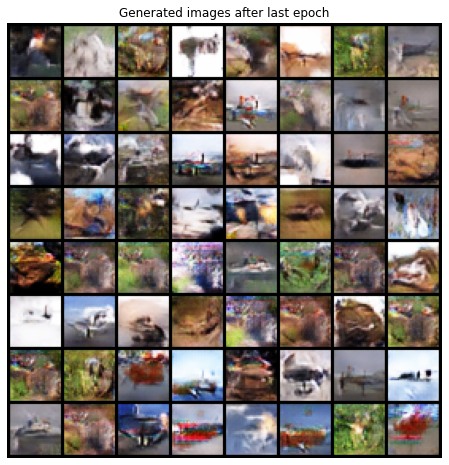

In [23]:
main()

In [24]:
!python3 /content/drive/MyDrive/LIIF/liif/demo.py --input /content/drive/MyDrive/GAN_proj/inference_imgs/fakeimg_5.png --model /content/drive/MyDrive/LIIF/liif/rdn-liif.pth --resolution 1024,1024 --output /content/drive/MyDrive/GAN_proj/inference_imgs/fakeimg_5_big.png --gpu 0

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
